In [1]:
# Submission for the Titanic challenge by M6sB5n  -final version using decision trees -0.78468  
import pandas as pd
#from sklearn.linear_model import LogisticRegression     
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, KBinsDiscretizer
from sklearn.tree import DecisionTreeClassifier, plot_tree
# We already got splitted test data. Following import just noted for completeness.
#from sklearn.model_selection import train_test_split as tts 

In [3]:
# read the data
df = pd.read_csv('data/train.csv',  index_col=0)
y = df['Survived']
#Since the test data does not contain the column 'Survived', i dropped it thereby pleasing the ColumnTransformer
df.drop(['Survived'], axis=1, inplace=True)   
# load test data
# Subsequent splitting needed, if data not yet divided. X input/independent data. y target/dependent data. random_state=<number> ensures determined randomnes.
#Xtrain, Xtest, ytrain, ytest = tts(df_X, df_y, random_state=42)

In [4]:
##################################### feature engeneering vfinal
#df.head()

In [5]:
# manual binning: all options presented by KBinDiscretizer upon this data set produce grouping in a mathematical but not biological sensical manner
# Thus manual bining within "reasonable" edges 
df['Age'] = pd.cut(df['Age'].fillna(df.groupby(['Pclass', 'Sex'])['Age'].transform('mean')), bins=(0,10,18,30,45,60,100), labels=['A0_10', 'A11_18','A19_30','A31_45','A46_60','A60_99']);

In [6]:
# Since Embarkment could correlate with survival chances by i.e.options of accommodation or embarkment habour as econimical attractor for certain classes(i.e by geography,
# infrastratur, ...)                   
pipeEmbarked = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(sparse=False, handle_unknown='ignore')
    #OneHotEncoder(sparse=False, handle_unknown='ignore')
)

In [40]:
trans_Sex_Pclass_Age_Emb = ColumnTransformer([
    ('Cat_Sex_Pclass', OneHotEncoder(sparse=False, handle_unknown='ignore'), ['Sex','Pclass']),
    #('Cat_Age', KBinsDiscretizer(n_bins=4, encode='onehot-dense', strategy='quantile'),['Age']),      # manual binning performed better
    ('Cat_Age', OneHotEncoder(sparse=False, handle_unknown='ignore'), ['Age']),    # needs binninig
    #('Cat_Fare', KBinsDiscretizer(n_bins=4, encode='onehot-dense', strategy='quantile'),['Fare']),    # decresed score... might be to strong correlated with Pclass
    ('Imp_Embarked', pipeEmbarked, ['Embarked']),
    #('Cat_Sib', OneHotEncoder(sparse=False, handle_unknown='ignore'), ['SibSp']),     #did not change the score
    #('Cat_Parch', 'passthrough', ['Parch'])                                           #not implemented
    #Name                                                                              #not immplemented
])

In [41]:
trans_Sex_Pclass_Age_Emb.fit(df);    #fits the transormer
df_train = trans_Sex_Pclass_Age_Emb.transform(df) 

In [42]:
#switch to decision tree model
model = DecisionTreeClassifier(max_depth=4)

In [49]:
# Fitting and Training the model
model.fit(df_train, y)    # trains the model
ypred_train = model.predict(df_train)  

In [50]:
# load and transform the test data
test = pd.read_csv('../data/test.csv',  index_col=0)
test['Age'] = pd.cut(test['Age'].fillna(test.groupby(['Pclass', 'Sex'])['Age'].transform('mean')),  bins=(0,10,18,30,45,60,100), labels=['A0_10', 'A11_18','A19_30','A31_45','A46_60','A60_99'])
#there is a missing value in the test data for the fares
#test['Fare'] = test['Fare'].fillna(test.groupby(['Pclass', 'Sex'])['Fare'].transform('mean'))

In [51]:
# transforming test data and applying model to create prediction and store it
test_trans= trans_Sex_Pclass_Age_Emb.transform(test)
ypred_test = model.predict(test_trans)
submission = pd.DataFrame(ypred_test, index=test.index, columns=['Survived'])
submission.to_csv('submissionfinal.csv')

### Evaluation


              precision    recall  f1-score   support

           0       0.80      0.96      0.87       549
           1       0.91      0.62      0.74       342

    accuracy                           0.83       891
   macro avg       0.86      0.79      0.81       891
weighted avg       0.84      0.83      0.82       891



(0.8305274971941639,
 None,
 <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x7f1dcbd6f520>)

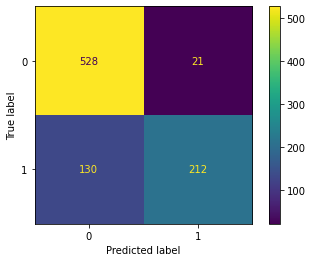

In [45]:
# classifiers evaluation. all evaluation is done on the train data as well, since the ypred_test is not available.
from sklearn.metrics import accuracy_score, classification_report, plot_confusion_matrix
accuracy_score(y, ypred_train),print(classification_report(y, ypred_train)), plot_confusion_matrix(model, df_train, y)   # model tested on the traiing data themself

### Comparison with former versions